**Dénes Csala**  
LSE, 2024  

Based on *Elements of Data Science* ([Allen B. Downey](https://allendowney.com), 2021) and *Python Data Science Handbook* ([Jake VanderPlas](https://jakevdp.github.io/PythonDataScienceHandbook/), 2018)

License: [MIT](https://mit-license.org/)

## Real-World Example: Random Forest for Classifying Goods by Inflation Type

Example from https://richarddavies.io/research/prices

In [2]:
import requests, json, pandas as pd

In [3]:
chart_spec=json.loads(requests.get('https://raw.githubusercontent.com/RDeconomist/prices/master/viz/chart_exploreCPI.json').content)

In [41]:
raw=pd.read_csv('https://raw.githubusercontent.com/RDeconomist/prices/master/analysis/db_priceChangesByProductAnnualLatestYear.csv')

In [5]:
import altair as alt
from IPython.display import display

In [6]:
display(alt.display.html_renderer(chart_spec), raw=True)

In [7]:
raw.columns

Index(['item_id', 'description', 'division', 'spanYears', 'year', 'up', 'down',
       'level', 'all', 'up12', 'down12', 'level12', 'all12', 'up_ch_median',
       'down_ch_median', 'up_ch12_median', 'down_ch12_median', 'up_ch_mean',
       'up_ch12_mean', 'down_ch_mean', 'down_ch12_mean', 'up_sh', 'down_sh',
       'up_sh12', 'down_sh12', 'group', 'yearMax', 'rankRise',
       'rankRiseLatest', 'inflationRank', 'up_sh12_longRun',
       'up_ch12_longRunMean', 'division_sh'],
      dtype='object')

In [8]:
raw.head(3)

,item_id,description,division,spanYears,year,up,down,level,all,up12,...,up_sh12,down_sh12,group,yearMax,rankRise,rankRiseLatest,inflationRank,up_sh12_longRun,up_ch12_longRunMean,division_sh
0,320122,20 FILTER - OTHER BRAND,2,15,2022,155,29,1167,1351,1114,...,0.973776,0.020979,202,2022,5,5,5,0.975106,0.067009,Alcohol & tobacco
1,320205,5 CIGARS: SPECIFY BRAND,2,35,2022,119,43,996,1158,961,...,0.964859,0.030120,202,2022,7,7,7,0.957421,0.065168,Alcohol & tobacco
2,430527,A4 PRINTER PAPER (500 REAM),9,15,2022,257,44,1033,1334,901,...,0.733116,0.056957,905,2022,109,109,109,0.340322,0.207226,Recreation & culture


#### **Idea**: all-in-one data exploration pipeline:
 - Fit a classifier based on existing classes in `Division`  
 - See if this classifier works *across years*?
 - *Cluste*r the points to create a new Division config
 - Conduct a *dimensionality reduction* to examine whether this new clustering configuraiton is better the old one 

##### Classification

In [12]:
raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 577 entries, 0 to 576
Data columns (total 33 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   item_id              577 non-null    int64  
 1   description          577 non-null    object 
 2   division             577 non-null    int64  
 3   spanYears            577 non-null    int64  
 4   year                 577 non-null    int64  
 5   up                   577 non-null    int64  
 6   down                 577 non-null    int64  
 7   level                577 non-null    int64  
 8   all                  577 non-null    int64  
 9   up12                 577 non-null    int64  
 10  down12               577 non-null    int64  
 11  level12              577 non-null    int64  
 12  all12                577 non-null    int64  
 13  up_ch_median         577 non-null    float64
 14  down_ch_median       574 non-null    float64
 15  up_ch12_median       577 non-null    flo

In [15]:
len(raw),len(raw['item_id'].unique())

(577, 577)

In [18]:
df=raw.drop(['description','division_sh'],axis=1).set_index('item_id')

In [19]:
df.head(3)

,division,spanYears,year,up,down,level,all,up12,down12,level12,...,down_sh,up_sh12,down_sh12,group,yearMax,rankRise,rankRiseLatest,inflationRank,up_sh12_longRun,up_ch12_longRunMean
item_id,,,,,,,,,,,,,,,,,,,,,
320122,2,15,2022,155,29,1167,1351,1114,24,6,...,0.021466,0.973776,0.020979,202,2022,5,5,5,0.975106,0.067009
320205,2,35,2022,119,43,996,1158,961,30,5,...,0.037133,0.964859,0.030120,202,2022,7,7,7,0.957421,0.065168
430527,9,15,2022,257,44,1033,1334,901,70,258,...,0.032984,0.733116,0.056957,905,2022,109,109,109,0.340322,0.207226


In [97]:
X = df[[i for i in df.columns if i!='division']].fillna(0)
y = df[[i for i in df.columns if i=='division']]['division'].values

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from scipy import stats
import matplotlib.pyplot as plt
# plt.style.available # list of available styles
plt.style.use('seaborn-v0_8-pastel')

In [37]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, random_state=0)
clf = RandomForestClassifier(n_estimators=100, random_state=0)
clf.fit(Xtrain, ytrain)
ypred = clf.predict(Xtest)

<ipython-input-37-c5c3fdede67b>:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf.fit(Xtrain, ytrain)


In [39]:
metrics.accuracy_score(ypred, ytest)

0.8689655172413793

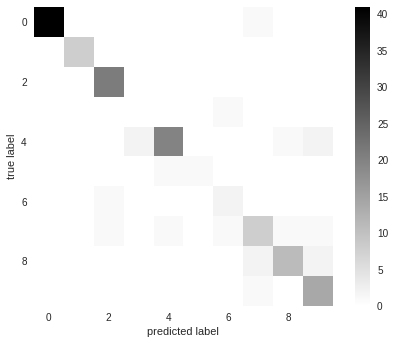

In [38]:
plt.imshow(metrics.confusion_matrix(ypred, ytest),
           interpolation='nearest', cmap=plt.cm.binary)
plt.grid(False)
plt.colorbar()
plt.xlabel("predicted label")
plt.ylabel("true label");

In [45]:
raw.set_index('division')['division_sh'].drop_duplicates()

division
2         Alcohol & tobacco
9      Recreation & culture
7                 Transport
5                 Household
6                    Health
1              Food & drink
3     Clothing and footwear
12                     Misc
11     Restaurants & Hotels
4       Housing & utilities
8             Communication
Name: division_sh, dtype: object

In [46]:
labels=raw.set_index('division')['division_sh'].drop_duplicates().values

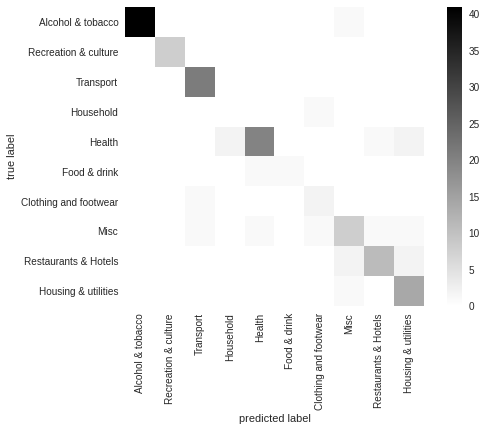

In [59]:
# plt.figure(figsize=(10,6))
plt.imshow(metrics.confusion_matrix(ypred, ytest),
           interpolation='nearest', cmap=plt.cm.binary)
plt.grid(False)
plt.colorbar()
plt.xlabel("predicted label")
plt.ylabel("true label");
plt.gca().set_yticks(range(len(labels)-1));
plt.gca().set_xticks(range(len(labels)-1));
plt.gca().set_yticklabels(labels);
plt.gca().set_xticklabels(labels,rotation=90);
plt.show()

##### Clustering

HC

In [60]:
import scipy.cluster.hierarchy as sch

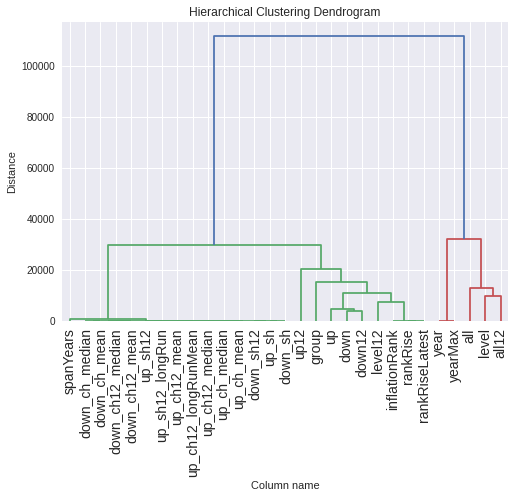

In [65]:
Z = sch.linkage(X.T, method='ward', metric='euclidean')

# Plot dendogram
# plt.figure(figsize=(25, 10))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Column name')
plt.ylabel('Distance')
sch.dendrogram(
    Z,
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=14.,  # font size for the x axis labels
    labels=X.columns
)
plt.show()

In [71]:
X2=raw.set_index('description').drop(['division_sh','division'],axis=1).fillna(0)

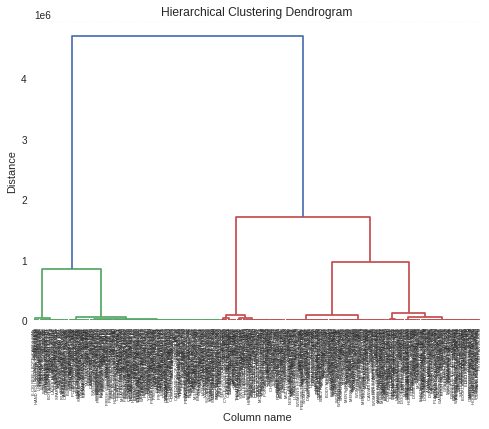

In [87]:
Z = sch.linkage(X2, method='ward', metric='euclidean')

# Plot dendogram
# plt.figure(figsize=(10, 70))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Column name')
plt.ylabel('Distance')
sch.dendrogram(
    Z,
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=4.,  # font size for the x axis labels
    labels=X2.index
)
plt.show()

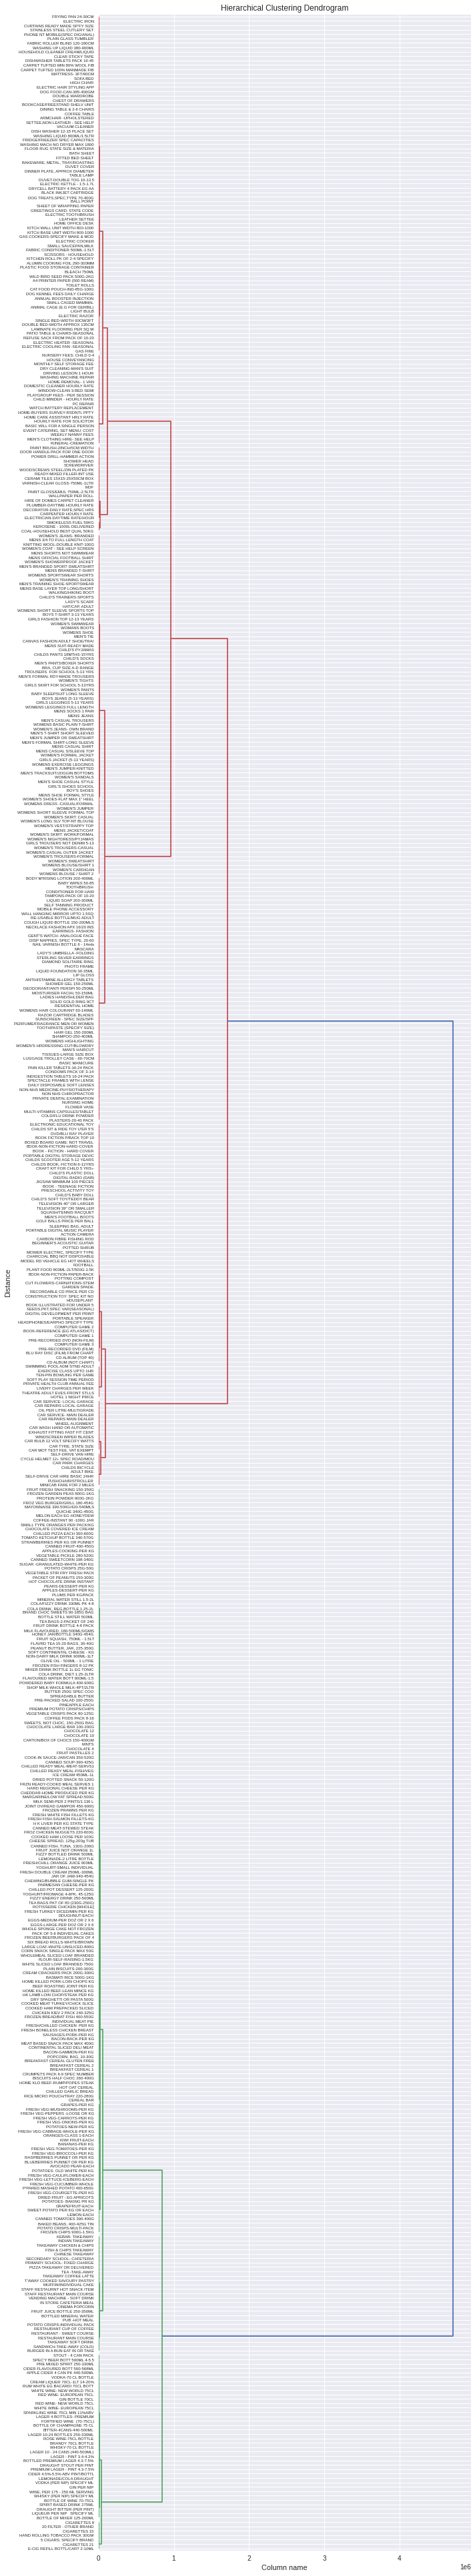

In [86]:
Z = sch.linkage(X2, method='ward', metric='euclidean')

# Plot dendogram
plt.figure(figsize=(10, 70))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Column name')
plt.ylabel('Distance')
sch.dendrogram(
    Z,
    # leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=6.,  # font size for the x axis labels
    labels=X2.index,
    orientation='right'
)
plt.show()

KMeans

In [89]:
from sklearn.cluster import KMeans

In [90]:
est = KMeans(n_clusters=len(labels))
clusters = est.fit_predict(X)
est.cluster_centers_.shape

(11, 29)

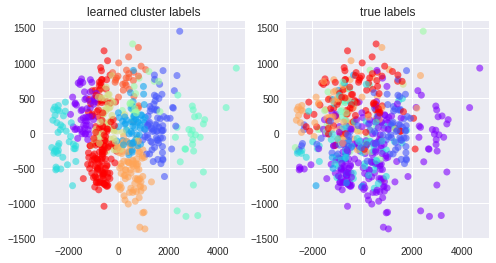

In [99]:
from sklearn.decomposition import PCA

W = PCA(2).fit_transform(X)

kwargs = dict(cmap=plt.cm.get_cmap("rainbow", 10), edgecolor="none", alpha=0.6)
fig, ax = plt.subplots(1, 2, figsize=(8, 4))
ax[0].scatter(W[:, 0], W[:, 1], c=clusters, **kwargs)
ax[0].set_title("learned cluster labels")

ax[1].scatter(W[:, 0], W[:, 1], c=y, **kwargs)
ax[1].set_title("true labels");

In [110]:
from sklearn.metrics import silhouette_score

The best value is 1 and the worst value is -1. Values near 0 indicate overlapping clusters.  
[Read more](https://medium.com/@cmukesh8688/silhouette-analysis-in-k-means-clustering-cefa9a7ad111)

In [108]:
silhouette_score(X, clusters) #learned clusters

0.27559657098081347

In [109]:
silhouette_score(X, y) #original clusters

-0.16991653084937067